<a href="https://colab.research.google.com/github/b4wolf/NEURALNETS/blob/main/model_lstm_graph_12_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and downloads

## Please refer to the readme for further directions on running.  

If you encounter an error running, ensure that the cells are run sequentially, and the necessary preprocessed files have been added to the content directory on colab.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from sklearn.impute import SimpleImputer

In [3]:
!pip install torch.geometric networkx torchvision

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import timedelta
import os
from google.colab import files
torch.manual_seed(1)
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv
import torch.utils.data as data

# Data Handling

In [5]:
station_data = []
for filename in os.listdir('.'):
  if '.csv' in filename:
    pm25_df = pd.read_csv(filename)
    station_data.append(np.array(pm25_df["Value"].values).reshape(-1, 1))

In [6]:
normalized_station_data = []
for stat in station_data:
  train_size = int(len(stat) * 0.70)
  test_size = len(stat) - train_size
  stat_train, stat_test = stat[:train_size], stat[train_size:]
  normalized_station_data.append([stat_train, stat_test])
print(len(normalized_station_data))

11


# LSTM

In [7]:
# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# Creates a series of lookback windows to be used for training and predicting window t+1
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [8]:
lookback = 7
station_train_dataset = []
station_test_dataset = []
for stat in normalized_station_data:
  X_train, y_train = create_dataset(stat[0], lookback=lookback)
  X_test, y_test = create_dataset(stat[1], lookback=lookback)
  station_train_dataset.append([X_train, y_train])
  station_test_dataset.append([X_test, y_test])

In [9]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=100, out_features=input_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [10]:
def plot(model, timeseries, train_size, X_train, y_train, X_test, y_test):
  with torch.no_grad():
      train_plot = np.ones_like(timeseries[:,0]) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1, 0]
      train_plot[lookback:train_size] = y_pred
      y_pred = model(X_test)
      y_pred = y_pred[:, -1, 0]
      test_plot = np.ones_like(timeseries[:,0]) * np.nan
      test_plot[train_size+lookback:len(timeseries[:,0])] = y_pred
  plt.plot(timeseries[:,0], c='#FFFDD0')
  plt.show()
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  plt.show()

<ipython-input-11-16d870f4867d>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 4.0796, test RMSE 1.9483, train MAE 1.5474, test MAE 0.9165
Epoch 1: train RMSE 3.1268, test RMSE 1.8502, train MAE 1.2394, test MAE 0.8653
Epoch 2: train RMSE 2.7126, test RMSE 1.8179, train MAE 1.1556, test MAE 0.8609
Epoch 3: train RMSE 2.4777, test RMSE 1.8086, train MAE 1.0833, test MAE 0.8483
Epoch 4: train RMSE 2.3730, test RMSE 1.8575, train MAE 1.1029, test MAE 0.8977
Epoch 5: train RMSE 2.2575, test RMSE 1.7945, train MAE 1.0314, test MAE 0.8311
Epoch 6: train RMSE 2.2024, test RMSE 1.8035, train MAE 1.0260, test MAE 0.8321
Epoch 7: train RMSE 2.1469, test RMSE 1.8070, train MAE 1.0021, test MAE 0.8190
Epoch 8: train RMSE 2.1253, test RMSE 1.8318, train MAE 1.0090, test MAE 0.8313
Epoch 9: train RMSE 2.0968, test RMSE 1.8451, train MAE 1.0349, test MAE 0.8670
Epoch 10: train RMSE 2.0776, test RMSE 1.8342, train MAE 1.0016, test MAE 0.8194
Epoch 11: train RMSE 2.0582, test RMSE 1.8510, train MAE 1.0184, test MAE 0.8492
Epoch 12: train RMSE 2.0961, test RMSE

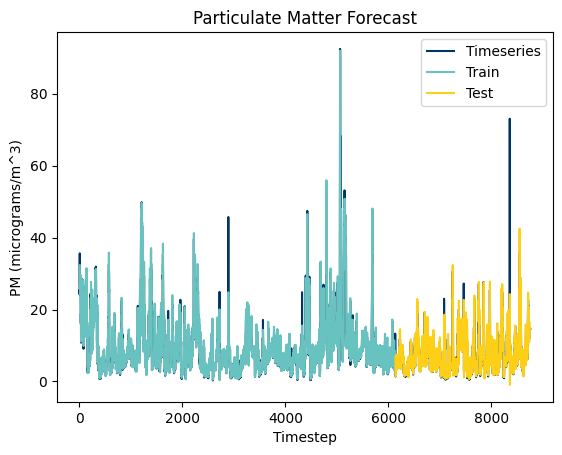

Epoch 0: train RMSE 2.9831, test RMSE 2.4469, train MAE 1.4368, test MAE 1.0983
Epoch 1: train RMSE 2.1784, test RMSE 2.2274, train MAE 1.1719, test MAE 1.0007
Epoch 2: train RMSE 1.8814, test RMSE 2.1767, train MAE 1.0696, test MAE 0.9507
Epoch 3: train RMSE 1.7266, test RMSE 2.1706, train MAE 1.0279, test MAE 0.9442
Epoch 4: train RMSE 1.6376, test RMSE 2.1660, train MAE 0.9963, test MAE 0.9283
Epoch 5: train RMSE 1.5976, test RMSE 2.1714, train MAE 0.9860, test MAE 0.9232
Epoch 6: train RMSE 1.5730, test RMSE 2.1884, train MAE 0.9769, test MAE 0.9274
Epoch 7: train RMSE 1.5602, test RMSE 2.1882, train MAE 0.9693, test MAE 0.9189
Epoch 8: train RMSE 1.5613, test RMSE 2.1997, train MAE 0.9797, test MAE 0.9315
Epoch 9: train RMSE 1.5701, test RMSE 2.2073, train MAE 0.9907, test MAE 0.9352
Epoch 10: train RMSE 1.5440, test RMSE 2.1919, train MAE 0.9771, test MAE 0.9308
Epoch 11: train RMSE 1.5352, test RMSE 2.1932, train MAE 0.9722, test MAE 0.9285
Epoch 12: train RMSE 1.5263, test RMSE

KeyboardInterrupt: ignored

In [11]:
station_data = []
for filename in os.listdir('.'):
  if '.csv' in filename:
    df = pd.read_csv(filename)
    timeseries = df[["Value"]].values.astype('float32')
    station_data.append(timeseries)

stat_train_predictions = []
stat_test_predictions = []
for timeseries in station_data:
  train_size = int(len(timeseries) * 0.70)
  test_size = len(timeseries) - train_size
  train, test = timeseries[:train_size], timeseries[train_size:]

  def create_dataset(dataset, lookback):
      """Transform a time series into a prediction dataset

      Args:
          dataset: A numpy array of time series, first dimension is the time steps
          lookback: Size of window for prediction
      """
      X, y = [], []
      for i in range(len(dataset)-lookback):
          feature = dataset[i:i+lookback]
          target = dataset[i+1:i+lookback+1]
          X.append(feature)
          y.append(target)
      return torch.tensor(X), torch.tensor(y)

  lookback = 7
  X_train, y_train = create_dataset(train, lookback=lookback)
  X_test, y_test = create_dataset(test, lookback=lookback)
  class AirModel(nn.Module):
      def __init__(self):
          super().__init__()
          self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
          self.linear = nn.Linear(50, 1)
      def forward(self, x):
          x, _ = self.lstm(x)
          x = self.linear(x)
          return x

  model = AirModel()
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.MSELoss()
  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

  n_epochs = 100
  for epoch in range(n_epochs):
      model.train()
      losses = []
      for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          losses.append(loss.detach().numpy())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # Validation
      model.eval()
      with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          train_mae = F.l1_loss(y_pred, y_train)
          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
          test_mae = F.l1_loss(y_pred, y_test)
      print("Epoch %d: train RMSE %.4f, test RMSE %.4f, train MAE %.4f, test MAE %.4f" % (epoch, train_rmse, test_rmse, train_mae, test_mae))

  with torch.no_grad():
      # shift train predictions for plotting
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      stat_train_predictions.append(y_pred[: -1, :])
      y_pred = y_pred[:, -1, :]
      print(y_pred.shape)
      train_plot[lookback:train_size] = model(X_train)[:, -1, :]
      # shift test predictions for plotting
      test_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_test)
      stat_test_predictions.append(y_pred[:, -1, :])
      test_plot[train_size+lookback:len(timeseries)] = y_pred[:, -1, :]
  plt.plot(timeseries, color='#003366',label='Timeseries')
  plt.plot(train_plot, color='#68C3C0',label='Train')
  plt.plot(test_plot, color='#FDD017',label='Test')
  plt.title('Particulate Matter Forecast')
  plt.ylabel("PM (micrograms/m^3)")
  plt.xlabel("Timestep")
  plt.legend()
  plt.savefig(f'{timeseries[0]}transparent_plot.png', transparent=True)
  plt.show()

In [11]:
stat_train_predictions[0].shape

torch.Size([6124, 7, 1])

# Now, the graph implementation

Processed monitor data must be uploaded each time

In [12]:
import torch
import folium
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from scipy.spatial.distance import euclidean
import os
import networkx as nx
from torch_geometric.data import Data
import math
from heapq import nsmallest
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt
import torch.optim as optim

In [13]:
directory_path = '/content/'
file_names = [file for file in os.listdir(directory_path) if 'monitor' in file and file.endswith('.csv')]
data_frames = []

for file_name in file_names:
    match = re.match(r'processed_monitor_([0-9.-]+)_([0-9.-]+)\.csv', file_name)
    if match:
        lat, lon = match.groups()
        lat, lon = float(lat), float(lon)
        try:
            df = pd.read_csv(os.path.join(directory_path, file_name))
            df['Latitude'] = lat
            df['Longitude'] = lon
            data_frames.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"No data in file: {file_name}")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    else:
        print(f"Filename pattern mismatch: {file_name}")

In [14]:
directory_path = '/content/'
file_names = glob.glob(os.path.join(directory_path, '*.csv'))

In [15]:
def haversine(coord1, coord2):
    R = 6371.0
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

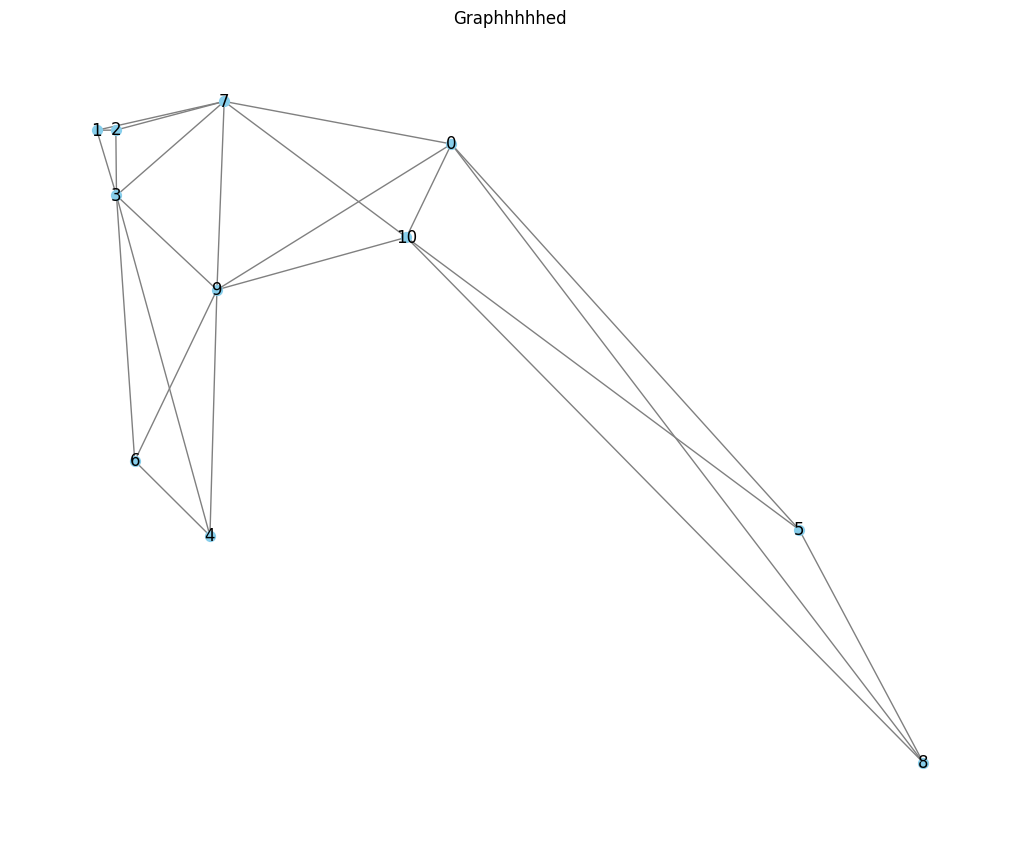

In [16]:
G = nx.Graph()
distances = {}
node_positions = {}

for i in range(len(data_frames)):
    coord1 = (data_frames[i]['Latitude'].iloc[0], data_frames[i]['Longitude'].iloc[0])
    node_positions[i] = coord1
    distances[i] = []

    for j in range(len(data_frames)):
        if i != j:
            coord2 = (data_frames[j]['Latitude'].iloc[0], data_frames[j]['Longitude'].iloc[0])
            distance = haversine(coord1, coord2)
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)

plt.figure(figsize=(10, 8))
nx.draw(G, pos=node_positions, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
plt.title("Graphhhhhed")
plt.show()


In [17]:
directory_path = '/content/'
pattern = re.compile(r'([0-9.-]+)_([0-9.-]+)\.csv')
lat_lon_pairs = []
for file_name in os.listdir(directory_path):
    if file_name.endswith('.csv'):
        match = pattern.search(file_name)
        if match:
            lat, lon = match.groups()
            lat_lon_pairs.append((float(lat), float(lon)))
print(lat_lon_pairs)

[(44.50729, -87.99344), (42.93257, -87.93434), (43.01724, -87.93369), (43.020075, -88.21507), (43.4351, -89.67979), (46.0519, -89.654), (43.10101, -89.35768), (43.4983, -87.8102), (46.60234, -90.65615), (43.46611, -88.62111), (44.30738, -88.39509)]


In [18]:
wisconsin_center = (44.5000, -89.5000)
map_wisconsin = folium.Map(location=wisconsin_center, zoom_start=7)
lat_lon_list = lat_lon_pairs

for lat, lon in lat_lon_list:
    folium.Marker(location=(lat, lon)).add_to(map_wisconsin)

In [19]:
example_tensor = stat_train_predictions[0]

In [20]:
example_tensor[0].shape

torch.Size([7, 1])

# Training Tensors and Testing tensor dataframes

In [21]:
columns = {}
for i, tensor in enumerate(stat_train_predictions):
    if isinstance(tensor, torch.Tensor) and tensor.shape == (6124, 7, 1):
        column = tensor[:, 6, :].squeeze()
        columns[f"{i+1}"] = column.numpy()
    else:
        raise ValueError(f"Item {i} in stat_train_predictions is not a tensor with shape [6124, 7, 1]")

df_tensor_11_train = pd.DataFrame(columns)

In [22]:
df_tensor_11_test = pd.DataFrame(torch.cat(tuple(stat_test_predictions), axis=1).numpy())

In [23]:
print(len(df_tensor_11_test))
print(len(df_tensor_11_train))

2621
6124


In [24]:
targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)

In [25]:
targets.shape

torch.Size([11, 8760, 1])

In [26]:
df_tensor_11_test.columns = df_tensor_11_test.columns.astype(str)
df_tensor_11_test.columns = [str(int(col)+1) for col in df_tensor_11_test.columns]
combined_df = pd.concat([df_tensor_11_train, df_tensor_11_test], axis=0, ignore_index=True)

In [27]:
len(combined_df)

8745

In [28]:
num_nodes = 11
edge_index = torch.tensor(list(G.edges())).t().contiguous()
print(edge_index.shape)
x = torch.tensor([combined_df[col].values for col in combined_df], dtype=torch.float)
print(x.shape)
targets = torch.tensor([df['Value'].values for df in data_frames], dtype=torch.float)
targets = targets[:, :8745]
print(targets.shape)
data = Data(x=x, edge_index=edge_index, y=targets)

torch.Size([2, 23])
torch.Size([11, 8745])
torch.Size([11, 8745])


In [29]:
print(data.x)

tensor([[22.4925, 22.4717, 22.4847,  ..., 14.8080, 14.8080, 14.8080],
        [20.9676, 20.9646, 20.8860,  ..., 19.0013, 19.0013, 19.0013],
        [21.1687, 21.1535, 20.9184,  ..., 18.3804, 18.3804, 18.3804],
        ...,
        [ 9.6207,  9.8886,  9.5153,  ...,  5.8653,  5.8653,  5.8653],
        [21.9843, 21.4092, 21.8232,  ..., 17.8800, 17.8800, 17.8800],
        [22.4931, 22.5621, 22.5459,  ..., 15.9313, 14.4973, 18.5829]])


# Graph

In [30]:
num_features = 2
num_classes = 8760

Epoch 0, Loss: 174.50802612304688, RMSE: 10.637572288513184, MAE: 8.050015449523926
Epoch 100, Loss: 119.17317199707031, RMSE: 10.270832061767578, MAE: 7.564424514770508
Epoch 200, Loss: 111.3056411743164, RMSE: 9.921794891357422, MAE: 7.098848819732666
Epoch 300, Loss: 104.0808334350586, RMSE: 9.592414855957031, MAE: 6.661956787109375
Epoch 400, Loss: 97.45133209228516, RMSE: 9.282215118408203, MAE: 6.254961967468262
Epoch 500, Loss: 91.36968231201172, RMSE: 8.990523338317871, MAE: 5.878169059753418
Epoch 600, Loss: 85.79057312011719, RMSE: 8.716593742370605, MAE: 5.53035831451416
Epoch 700, Loss: 80.6715316772461, RMSE: 8.459636688232422, MAE: 5.210792541503906
Epoch 800, Loss: 75.97314453125, RMSE: 8.218847274780273, MAE: 4.920391082763672
Epoch 900, Loss: 71.6590805053711, RMSE: 7.993423938751221, MAE: 4.66248083114624
Epoch 1000, Loss: 67.69600677490234, RMSE: 7.782571792602539, MAE: 4.43643045425415
Epoch 1100, Loss: 64.0534439086914, RMSE: 7.585515975952148, MAE: 4.2397866249084

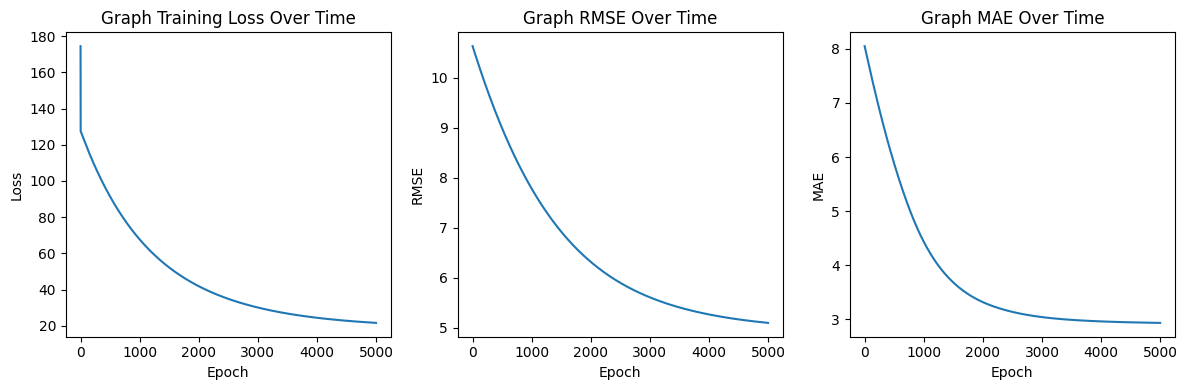

In [31]:
# Train/Test split
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_size = int(num_nodes * 0.7)

train_mask[:train_size] = True
test_mask[train_size:] = True

data.train_mask = train_mask
data.test_mask = test_mask

class BasicGNN(torch.nn.Module):
    def __init__(self, num_features, num_outputs):
        super(BasicGNN, self).__init__()
        self.conv1 = SAGEConv(num_features, 16)
        self.conv2 = SAGEConv(16, num_outputs)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x


model = BasicGNN(num_features=x.size(1), num_outputs=8745)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

loss_values = []
rmse_values = []
mae_values = []
predictions_list = []
for epoch in range(5000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

    # Calculate RMSE and MAE
    with torch.no_grad():
        model.eval()
        predictions = model(data)
        predictions_list.append(predictions)
        rmse = torch.sqrt(criterion(predictions[data.test_mask], data.y[data.test_mask]))
        mae = torch.mean(torch.abs(predictions[data.test_mask] - data.y[data.test_mask]))
        rmse_values.append(rmse.item())
        mae_values.append(mae.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, RMSE: {rmse.item()}, MAE: {mae.item()}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graph Training Loss Over Time')

plt.subplot(1, 3, 2)
plt.plot(rmse_values)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Graph RMSE Over Time')

plt.subplot(1, 3, 3)
plt.plot(mae_values)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Graph MAE Over Time')

plt.tight_layout()
plt.show()

# evaluation for embedding collapse

In [32]:
len(predictions_list[0][0])

8745

In [33]:
model.eval()
with torch.no_grad():
    pred = model(data).squeeze()
    test_pred = pred[data.test_mask]
    test_targets = data.y[data.test_mask]
    mse = torch.mean((test_pred - test_targets) ** 2)
    print(f'Mean Squared Error (MSE): {mse.item()}')
    rmse = torch.sqrt(mse)
    print(f'Root Mean Squared Error (RMSE): {rmse.item()}')
    target_mean = test_targets.mean()
    total_variance = torch.sum((test_targets - target_mean) ** 2)
    residual_variance = torch.sum((test_targets - test_pred) ** 2)
    r2_score = 1 - (residual_variance / total_variance)
    print(f'R² Score: {r2_score.item()}')
    embeddings = model(data).detach().cpu().numpy()

Mean Squared Error (MSE): 25.956682205200195
Root Mean Squared Error (RMSE): 5.0947699546813965
R² Score: 0.4628732204437256


In [34]:
guess = embeddings[6]
guess_series = pd.Series(guess)

In [35]:
len(embeddings)

11

In [36]:
embeddings[0] == embeddings[1]

array([ True,  True,  True, ...,  True,  True,  True])

In [37]:
embeddings[0]

array([19.49066 , 19.250494, 19.621944, ..., 15.988597, 15.995268,
       16.053988], dtype=float32)

In [38]:
truth = combined_df['1']

In [39]:
truth == guess_series

0       False
1       False
2       False
3       False
4       False
        ...  
8740    False
8741    False
8742    False
8743    False
8744    False
Length: 8745, dtype: bool

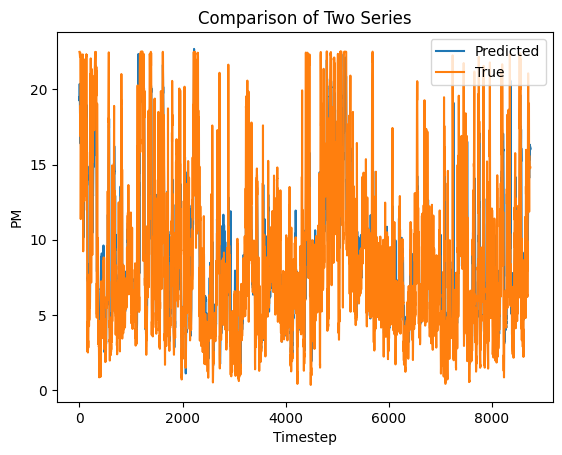

In [40]:
plt.plot(guess_series, label='Predicted')
plt.plot(truth, label='True')
plt.xlabel('Timestep')
plt.ylabel('PM')
plt.title('Comparison of Two Series')
plt.legend()
plt.show()
